# Data Standardization

In this script we analyze details of the images and standardize them in a pre-training phase (before the model training)

# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduces the amount of coding that would be needed when interacting with Google API

In [1]:
# First check if running on Google Colab

from google.colab import drive

# Install required packages
! pip install pandarallel
! pip install opencv-python

# Mount Drive
drive.mount("/content/gdrive", force_remount=True)

IN_COLAB = True
file_placement = "/content/gdrive/MyDrive/09 CS659 Image Processing and Analysis/data"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=49bd1b60f409c3ab792e6b46cc4af292df9ff971e2cc788889e1474d0f54beb8
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Mounted at /content/gdrive


Here we load the index we have created for Train and Test images, in order to check some of the images and then make decisions around the pre-processing of them

In [3]:
import os
import pandas as pd

base_folder = os.path.join(file_placement, "..")
train_and_test = pd.read_excel(os.path.join(base_folder, "train_and_test_set.xlsx"))

In [4]:
train_and_test["new_file_name"] = train_and_test.index + 1
train_and_test["new_file_name"] = train_and_test["new_file_name"].astype(str)
train_and_test["new_file_name"] = "img" + train_and_test["new_file_name"].str.rjust(5, "0") + ".png"
train_and_test

,path,set,label,file_name,fruit,fresh,image_info,height,width,channels,pixels_per_channel,total_of_features,total_of_features_rgb,new_file_name
0,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,a_r685.png,apples,False,"(402, 444, 4)",402,444,4,178488,713952,535464,img00001.png
1,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,freshapples,Screen Shot 2018-06-08 at 5.15.52 PM.png,apples,True,"(426, 448, 4)",426,448,4,190848,763392,572544,img00002.png
2,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,freshapples,Screen Shot 2018-06-08 at 5.05.18 PM.png,apples,True,"(172, 184, 4)",172,184,4,31648,126592,94944,img00003.png
3,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,freshapples,a_f677.png,apples,True,"(410, 374, 3)",410,374,3,153340,460020,460020,img00004.png
4,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,freshapples,a_f342.png,apples,True,"(224, 238, 3)",224,238,3,53312,159936,159936,img00005.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6700,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,a_r149.png,apples,False,"(420, 440, 3)",420,440,3,184800,554400,554400,img06701.png
6701,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,translation_Screen Shot 2018-06-07 at 2.53.33 ...,apples,False,"(408, 334, 3)",408,334,3,136272,408816,408816,img06702.png
6702,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,a_r812.png,apples,False,"(358, 376, 3)",358,376,3,134608,403824,403824,img06703.png
6703,/content/gdrive/MyDrive/09 CS659 Image Process...,Test,freshapples,a_f205.png,apples,True,"(164, 208, 3)",164,208,3,34112,102336,102336,img06704.png


We used [OpenCV](https://opencv.org/), a popular library for manipulating images.

Below some plots of those images and their transformation steps.

0.76 (380, 400, 3)


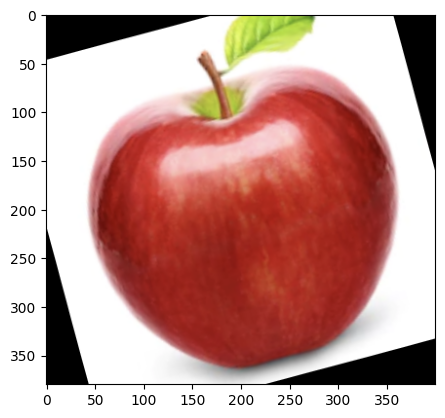

0.812 (406, 400, 3)


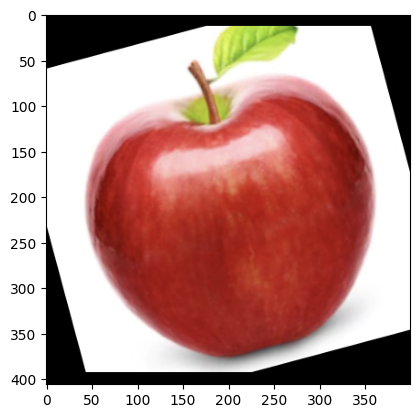

1.024 (512, 512, 3)


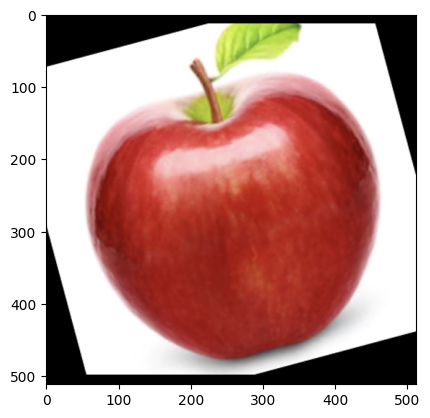

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_and_pad(image, height = 512, width = 512, padColor = 0):
    h, w, c = image.shape
    size = (height, width)
    sh, sw = size

    # Remove alpha channel if the image has 4 channels
    image_with_4th_channel = None
    if c > 3:
        image_with_4th_channel = image
        image = image[:,:,:3]

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(image.shape) == 3 and not isinstance(padColor, (list, tuple,
        np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3
    padded_image = cv2.copyMakeBorder(image, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)


    # Recalc the aspect ratio
    aspect = w/h
    scaled_img = cv2.resize(image, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)

#     plt.imshow(scaled_img)
    return image_with_4th_channel, padded_image, scaled_img

sample_max_width = (train_and_test[train_and_test["fresh"] == True]).sample(n=1)
image_path = sample_max_width.iloc[0]["path"]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_with_4th_channel, padded_image, scaled_image = resize_and_pad(image)

print(image.shape[0] * 2 / 1000, image.shape)
# plt.subplot(1, 4, 1)
plt.imshow(image)
plt.show()

if image_with_4th_channel is not None:
    # plt.subplot(1, 4, 2)
    print(image_with_4th_channel.shape[0] * 2 / 1000, image_with_4th_channel.shape)
    plt.imshow(image_with_4th_channel)
    plt.show()

# plt.subplot(1, 4, 3)
print(padded_image.shape[0] * 2 / 1000, padded_image.shape)
plt.imshow(padded_image)
plt.show()

# plt.subplot(1, 4, 4)
print(scaled_image.shape[0] * 2 / 1000, scaled_image.shape)
plt.imshow(scaled_image)
plt.show()

After some tests, we decided to resize all the images to 512x512 pixels, while keeping their aspect ratio by padding whenever needed with black pixels. We will save the pre-processed images on a different folder, then we don't need to run the same tasks every time we need to experiment with the algorithms for training and testing the model.

An important thing to note is that we are standardizing the name of the files, because PyTorch has some problems when reading folders that contain files with special characters on their name and/or images which are not in .png format. So, when transforming and saving, all of them are being saved using a random name and in .png format.

In [6]:
image_info = train_and_test.iloc[0]

def standardize_images(image_info):
    try:
        # print(image_info)
        fresh_path = os.path.join(base_folder, "transformed_images", "fresh")
        if not os.path.exists(fresh_path):
            os.makedirs(fresh_path)

        not_fresh_path = os.path.join(base_folder, "transformed_images", "notfresh")
        if not os.path.exists(not_fresh_path):
            os.makedirs(not_fresh_path)

        original_path = image_info["path"]
        image = cv2.imread(original_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image_with_4th_channel, padded_image, transformed_image = resize_and_pad(image)
        # plt.imshow(transformed_image)
        if image_info["fresh"]:
            new_placement = os.path.join(fresh_path, image_info["new_file_name"])
        else:
            new_placement = os.path.join(not_fresh_path, image_info["new_file_name"])
        cv2.imwrite(new_placement, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
    except Exception as e:
        print(f"image {original_path} standardized: {str(e)}")

standardize_images(train_and_test.iloc[1])

In [8]:
from pandarallel import pandarallel

max_cpu_cores = min(os.cpu_count(), 4)

pandarallel.initialize(progress_bar = True, nb_workers = max_cpu_cores)
train_and_test = train_and_test.parallel_apply(standardize_images, axis=1)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Just double checking if all the 6705 images were transformed and loaded in the new path

In [19]:
import pathlib

new_placement = "/content/gdrive/MyDrive/09 CS659 Image Processing and Analysis/transformed_images"
dataset = list(pathlib.Path(new_placement).rglob("*"))
dataset_df = pd.DataFrame(dataset)
dataset_df["path"] = dataset_df[0].astype(str)
i = dataset_df.columns.get_loc(0)
dataset_split = dataset_df["path"].str.split('/',expand=True)
dataset_df = pd.concat([dataset_df.iloc[:, i+1:], dataset_split], axis=1)
dataset_df = dataset_df[dataset_df[7].notnull()]

len(dataset_df.index)

6705